In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
from itertools import product, combinations
import pandas as pd

from paths import *
from ssd_paths import *
from misc_recorder import *

In [43]:
hyper_dir = model_save_
ts = "0121181130"
plot_save_place = "./plots/"
csv_path = os.path.join(hyper_dir, "runres.csv")

In [44]:
class ResReader: 
    def __init__(self, dir, runtype="ff", cv="full"):
        self.dir = dir
        self.runtype = runtype
        self.cv = cv
    
    def read(self):
        read_dir = os.path.join(self.dir, self.cv, self.runtype)
        train = ListRecorder(os.path.join(read_dir, 'train.acc'))
        valid = ListRecorder(os.path.join(read_dir, f'valid.acc'))
        fullvalid = ListRecorder(os.path.join(read_dir, f'full_valid.acc'))
        trainlikevalid = ListRecorder(os.path.join(read_dir, f'trainlikevalid.acc'))
        train.read()
        valid.read()
        fullvalid.read()
        trainlikevalid.read()
        return train.get(), valid.get(), fullvalid.get(), trainlikevalid.get()

## Collect the results from 10 runs, mark all variables. 

In [58]:
total_df = pd.DataFrame(columns=["run", "epoch", "train_filter_cond", "valid_filter_cond", "valid_phone_cond", "acc"])

for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        assert len(res[0]) == len(res[1])
        epochs = list(range(len(res[0])))

        for oneres, valid_filter, valid_phone, type_name in zip(
            res, 
            [runtype, runtype, "ff", runtype], 
            ["cv", cv, cv, "cv"], 
            ["train", "target_valid", "full_valid", "trainlike_valid"]
        ): 
            resdict = {
                "run": run_case, 
                "epoch": epochs, 
                "train_filter_cond": runtype, 
                "valid_filter_cond": valid_filter, 
                "valid_phone_cond": valid_phone, 
                "type_name": type_name, 
                "acc": oneres, 
            }

            df = pd.DataFrame(resdict)
            total_df = pd.concat([total_df, df], axis=0)

/tmp/ipykernel_218035/322722103.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, df], axis=0)


In [62]:
selected_df = total_df[total_df["epoch"].isin([15, 16, 17, 18, 19])]

In [63]:
selected_df

,run,epoch,train_filter_cond,valid_filter_cond,valid_phone_cond,acc,type_name
15,1,15,lf,lf,cv,0.276674,train
16,1,16,lf,lf,cv,0.280486,train
17,1,17,lf,lf,cv,0.281650,train
18,1,18,lf,lf,cv,0.285061,train
19,1,19,lf,lf,cv,0.285743,train
...,...,...,...,...,...,...,...
15,10,15,hf,hf,cv,0.241765,trainlike_valid
16,10,16,hf,hf,cv,0.245805,trainlike_valid
17,10,17,hf,hf,cv,0.236793,trainlike_valid
18,10,18,hf,hf,cv,0.244873,trainlike_valid


In [64]:
selected_df.to_csv(os.path.join(hyper_dir, "stackout_1519.csv"), index=False)

In [60]:
total_df.to_csv(os.path.join(hyper_dir, "stackout.csv"), index=False)

In [39]:
total_df[total_df["trainlike_valid"] < 0.1].to_csv(os.path.join(hyper_dir, "badout.csv"), index=False)

In [27]:
def draw(reses, y_label="Accuracy", title=""): 
    data = list(reses.values())

    # Function to calculate mean and 95% CI
    def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)
        margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
        return mean, margin

    # Calculate means and CIs
    means = [mean_confidence_interval(group)[0] for group in data]
    cis = [mean_confidence_interval(group)[1] for group in data]

    # Plotting
    fig, ax = plt.subplots()
    x_pos = np.arange(len(data))
    ax.bar(x_pos, means, yerr=cis, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(reses.keys())
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Show the plot
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(plot_save_place, f"{ts}-{title}.png"))

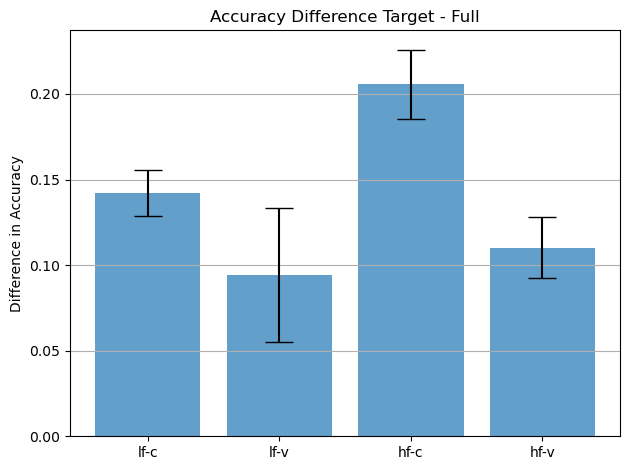

In [28]:
# TFD
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        val = np.mean([x - y for x, y in zip(res[1], res[2])][15:20])
        # val = np.mean(res[2][35:40])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses, "Difference in Accuracy", "Accuracy Difference Target - Full")

In [29]:
for a, b in list(combinations(reses.keys(), 2)): 
    print(a, b, stats.ttest_ind(reses[a], reses[b]))

lf-c lf-v TtestResult(statistic=2.622978165451204, pvalue=0.017244789284440502, df=18.0)
lf-c hf-c TtestResult(statistic=-5.947014725844747, pvalue=1.2564032808859191e-05, df=18.0)
lf-c hf-v TtestResult(statistic=3.225672355581972, pvalue=0.004690034399977199, df=18.0)
lf-v hf-c TtestResult(statistic=-5.740652656646264, pvalue=1.9251442341695983e-05, df=18.0)
lf-v hf-v TtestResult(statistic=-0.8402834027913818, pvalue=0.4117725039353932, df=18.0)
hf-c hf-v TtestResult(statistic=7.999889008674562, pvalue=2.451204818538007e-07, df=18.0)


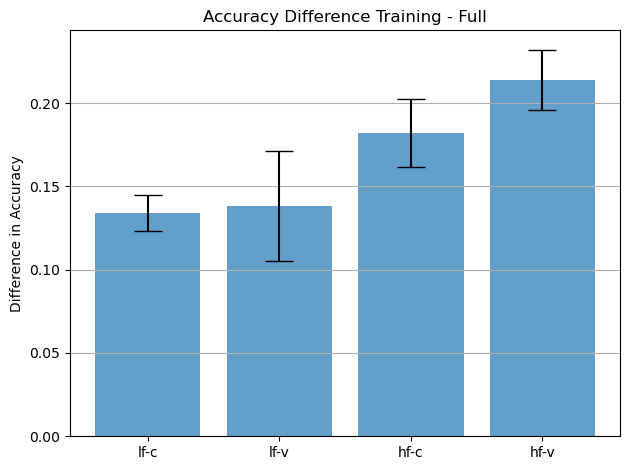

In [30]:
# TrainFD
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        # val = np.mean(res[2][35:40])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses, "Difference in Accuracy", "Accuracy Difference Training - Full")

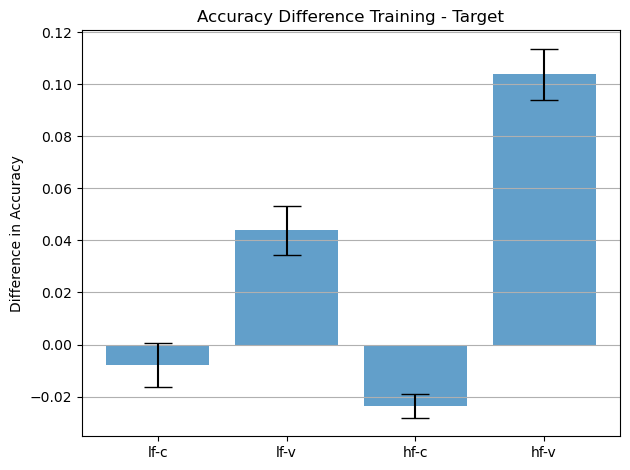

In [31]:
# TrainTD
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        val = np.mean([x - y for x, y in zip(res[0], res[1])][15:20])
        # val = np.mean(res[2][35:40])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses, "Difference in Accuracy", "Accuracy Difference Training - Target")

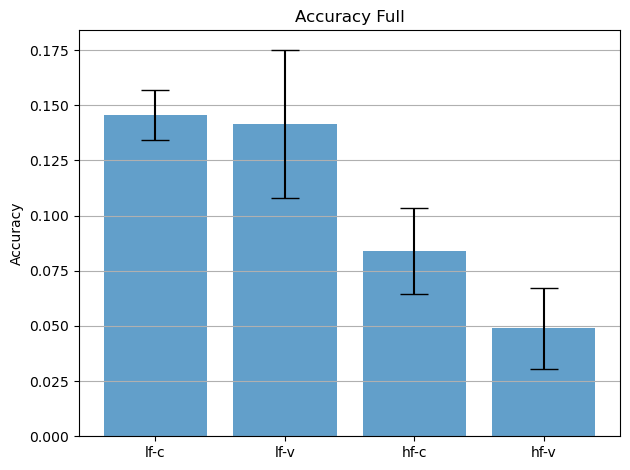

In [32]:
# FA
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        # val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        val = np.mean(res[2][15:20])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses, "Accuracy", "Accuracy Full")

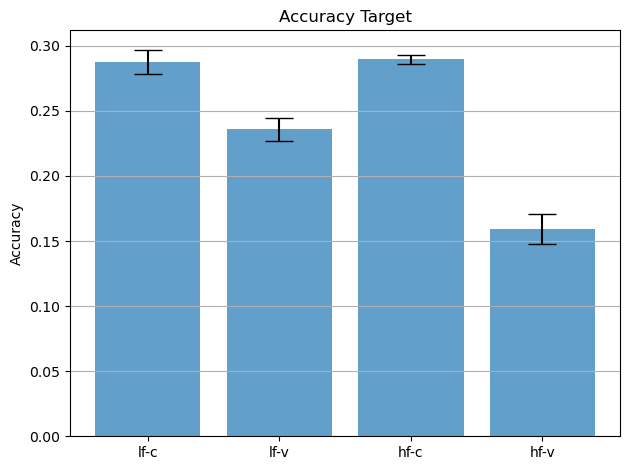

In [33]:
# TA
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        # val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        val = np.mean(res[1][15:20])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses, "Accuracy", "Accuracy Target")

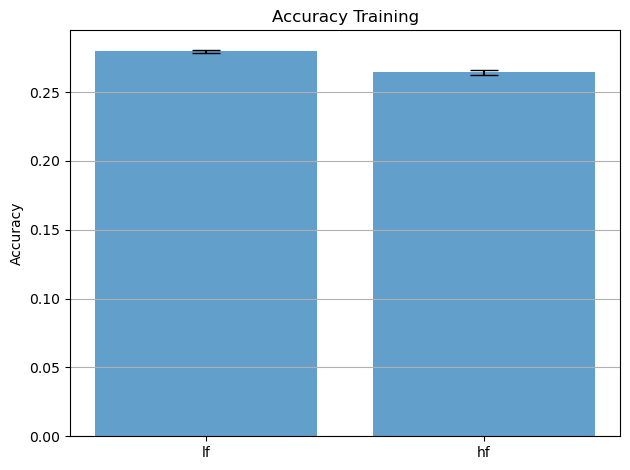

In [34]:
# TA
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        # val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        val = np.mean(res[0][15:20])
        if f"{runtype}" in reses.keys(): 
            reses[f"{runtype}"].append(val)
        else: 
            reses[f"{runtype}"] = [val]

draw(reses, "Accuracy", "Accuracy Training")